# NS-F Network Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from ns_f import *

Create global classes:
- **data**: Predefinded list of fixed size that tracks all packages in the network. This class is shared among all elements of the network and has a fixed size. Packets that leave the network (reach the destination) are deleted from data and make space for new packets. 

In [2]:
dat = data(packet_list_size=1000)

Let's quickly check the (first three elements of) dat table:

In [3]:
dat.package_list.head(3)

,circuit,ts,tr
0,NaN,inf,inf
1,NaN,inf,inf
2,NaN,inf,inf


Note again that the table is blank. There are no packages in the network just yet.
Later the current status of each package is tracked with lists of indices refering to this table. **This is a very important concept**: Whenever a packet is in a buffer, in transit or processed, lists of indices are read, copied, altered or stored.

Create a setup dict for all the servers (nodes) that are created. For the test, all servers will have the same properties.
- **v_max**: Maximum number of packets that can be send per second
- **s_max**: Maximum number of packets that can be (combined) in all the input/output buffers of the server
- **timeout**: time duration after which a sent packet is considered 'lost'. Timeout will trigger to adjust the window size.

In [4]:
setup_dict = {}
setup_dict['v_max'] = 2000   # packets / s
setup_dict['s_max'] = 10     # packets
setup_dict['timeout'] = 0.03    # s

Lets create some objects:

In [5]:
input_1  = server(setup_dict, dat, name='input_1' )
input_2  = server(setup_dict, dat, name='input_2' )
output_1 = server(setup_dict, dat, name='output_1')
output_2 = server(setup_dict, dat, name='output_2')
server_1 = server(setup_dict, dat, name='server_1')
server_2 = server(setup_dict, dat, name='server_2')

And define the routes of two circuits through the network:

In [6]:
circuits = [
    {'route': [input_1, server_1, server_2, output_1]},
    {'route': [input_2, server_1, server_2, output_2]},
]

Note that the server objects and the circuits definition mirror the API of the "optimal traffic scheduler" objects (OTS) that are used for the distributed control.

Finally we create the network class, which needs only the data object from above for its "__init__". We can optionally define the timestep and initial time (in seconds):

In [7]:
nw = network(data=dat, t0=0, dt=0.01)

The first method we invoke is ```.from_circuits.``` This will create a table of nodes and connections and determine some relevant properties:

In [8]:
nw.from_circuits(circuits)

If graph_tool is available, we can quickly visualize the network. The important objects: **connections** and **nodes** will be discussed below.

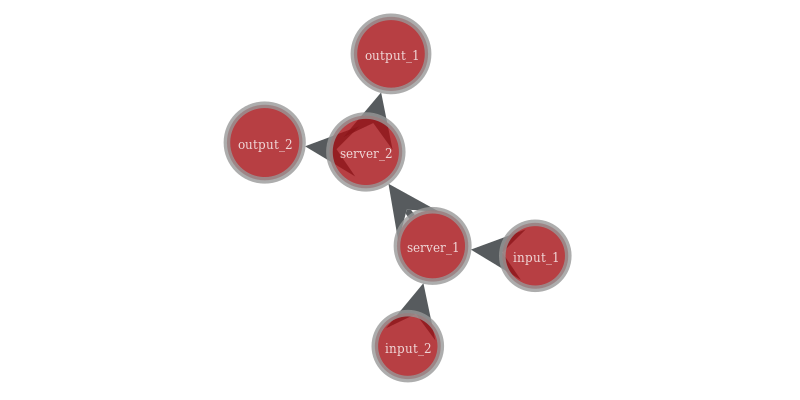

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f945ac20438, at 0x7f94429efda0>

In [9]:
import graph_tool.all as gt
edge_list, node_list = nw.connections, nw.nodes

# Create Graph and populate with edges and vertices:
g = gt.Graph()
vert_prop = {}
vert_prop['text'] = g.new_vertex_property('string')

node_list['vert'] = None
for i, node_i in node_list.iterrows():
    node_list['vert'][i] = g.add_vertex()
    vert_prop['text'][node_list['vert'][i]] = node_i['name']
# Add an edge to the graph for every connection and 
# save it with the respective 'source' and 'target' objects:
edge_list['edge'] = None
for i, edge_i in edge_list.iterrows():
    source_i = node_list[node_list['node'] == edge_i['source']]
    target_i = node_list[node_list['node'] == edge_i['target']]
    edge_list['edge'][i] = g.add_edge(source_i.vert.values[0], target_i.vert.values[0])
    
pos = gt.sfdp_layout(g, K=0.5)
gt.graph_draw(g, pos=pos, vprops=vert_prop, output_size=[800,400])

Lets investigate these objects. First the nodes:

In [10]:
nw.nodes

,node,name,con_target,n_in,con_source,n_out,output_circuits,vert
0,<ns_f.server object at 0x7f945ac58e48>,input_1,"[False, False, False, False, False]",0,"[True, False, False, False, False]",1,[[0]],0
1,<ns_f.server object at 0x7f945ac58f60>,server_1,"[True, False, False, True, False]",2,"[False, True, False, False, False]",1,"[[0, 1]]",1
2,<ns_f.server object at 0x7f945ac58f98>,server_2,"[False, True, False, False, False]",1,"[False, False, True, False, True]",2,"[[0], [1]]",2
3,<ns_f.server object at 0x7f945ac58ef0>,output_1,"[False, False, True, False, False]",1,"[False, False, False, False, False]",0,None,3
4,<ns_f.server object at 0x7f945ac58e80>,input_2,"[False, False, False, False, False]",0,"[False, False, False, True, False]",1,[[1]],4
5,<ns_f.server object at 0x7f945ac58f28>,output_2,"[False, False, False, False, True]",1,"[False, False, False, False, False]",0,None,5


- **node / name**: Reference to one of the server objects that were created above.
- **n_in**: Number of inputs
- **n_out**: Number of output

- **con_source**: For which connections is the current node the source (Note that this boolean array has the same number of elements as the number of connections).
- **con_target**: Similarly, for which connections the current node is the target
- **output_circuits**: A lwst item for each output_buffer that contains the circuits that are in this buffer
- **vert**: Only appears if graph_tool was used and is used only for visualization.

The server objects is also worth investigating:

In [11]:
nw.nodes.loc[0].node.__dict__ # for example for 'input_1'

{'data': <ns_f.data at 0x7f94848ba128>,
 'obj_name': 'input_1',
 's_max': 10,
 'v_max': 2000,
 'timeout': 0.03,
 's': 0,
 'n_in': 0,
 'n_out': 1,
 'input_buffer': [],
 'output_buffer': [[]]}

Now the connections:

In [12]:
nw.connections

,source,target,circuit,source_name,target_name,latency_fun,window_size,window,transit,transit_reply,source_ind,target_ind,edge
0,<ns_f.server object at 0x7f945ac58e48>,<ns_f.server object at 0x7f945ac58f60>,[0],input_1,server_1,<function network.analyze_connections.<locals>...,2,[],[],[],0,0,"(0, 1)"
1,<ns_f.server object at 0x7f945ac58f60>,<ns_f.server object at 0x7f945ac58f98>,"[0, 1]",server_1,server_2,<function network.analyze_connections.<locals>...,2,[],[],[],0,0,"(1, 2)"
2,<ns_f.server object at 0x7f945ac58f98>,<ns_f.server object at 0x7f945ac58ef0>,[0],server_2,output_1,<function network.analyze_connections.<locals>...,2,[],[],[],0,0,"(2, 3)"
3,<ns_f.server object at 0x7f945ac58e80>,<ns_f.server object at 0x7f945ac58f60>,[1],input_2,server_1,<function network.analyze_connections.<locals>...,2,[],[],[],0,1,"(4, 1)"
4,<ns_f.server object at 0x7f945ac58f98>,<ns_f.server object at 0x7f945ac58f28>,[1],server_2,output_2,<function network.analyze_connections.<locals>...,2,[],[],[],1,0,"(2, 5)"


Where **source** and **target** are again referencing server objects (with their respective name) and **circuit** is a list of all circuits that are carried in this connections. **source_ind** and **target_ind** are very important: Each server has as many output buffer as the number of outgoing connections. These are stored as a list. To find the relevant output_buffer of the source for the current connection, the **source_ind** has to be used as index as in: ```source.output_buffer[source_ind]```.
**Edge** only appears if graph_tool was used and is used only for visualization.

Important properties of the connection are:
- **latency_fun**: Function that returns the latency of the connection given the time of sending.
- **window_size**: Size of the current congestion window
- **window**: List of indices that again refer to the ```data.package_list``` and denote which packets are sent/ supposed to be sent in the current window
- **transit**: List of (indices of) packets that are in transit
- **transit_reply**: List of (indices of) packets that were received at the target node and triggered a reply. Packets can only either be in transit or transit_reply.

Now that everything is set up, we can add some intial packages to the inputs and run a couple of simulation steps. First the initial packages:

In [13]:
input_1.add_2_buffer(buffer_ind=0, circuit=0, n_packets=20)
input_2.add_2_buffer(buffer_ind=0, circuit=1, n_packets=20)

As we can see, the data object is now populated:

In [14]:
dat.package_list.head(4)

,circuit,ts,tr
0,0,inf,inf
1,0,inf,inf
2,0,inf,inf
3,0,inf,inf


The simulation of one timestep is invoked with .simulate():

In [15]:
nw.simulate()

What has happened now? Simulate is a list of operations that are executed for each connection.
```python
for i, con in self.connections.iterrows()
    ...
```
### 1. Check timeout
Check if any packages of the previous congestion window reached a "timeout". This is not relevant in the first step as the window is still empty.

### 2. Send packages
Populate the window, if it is empty.
1. We determine the packages that will be send, by
   - Checking the respective buffer of the source of the current connection (```con.source```) with 
   ```python 
   source_buffer = con.source.output_buffer[con.source_ind]
   ```
   - Determine how many many packages will be sent:
   ```python 
   n_send = min(con.window_size, len(source_buffer), int(con.source.v_max*dt))
   ```
   Where the number of packets cant exceeed the allowed window size, we can't send more than we have and also there is a limit to the number of packets we can sent per time. The packets that are supposed to be sent in the current window but violate the last condition are therefore sent in the following timestep.
   
2. We send the packages by adding the indices that refer to the package_list in 'data' to (Note that the sum operations for list results in concatenation.):
   - 
   ```python 
   con.window  += send_ind
   ```
   - 
   ```python 
   con.transit += send_ind
   ```
   

3. We update the time in the package_list in 'data' for the packets that have been sent.
   ```python 
   self.data.package_list.loc[send_ind, 'ts'] = self.t
   ```
   Where 'ts' stands for time sent.
   
Let's quickly check the respective lists for the connection from input_1 to server_1:

In [16]:
print('nw.connections.loc[0].window = {}'.format(nw.connections.loc[0].window))
print('nw.connections.loc[0].transit = {}'.format(nw.connections.loc[0].transit))
dat.package_list.head(4)

nw.connections.loc[0].window = [0, 1]
nw.connections.loc[0].transit = [0, 1]


,circuit,ts,tr
0,0,0.000000,inf
1,0,0.000000,inf
2,0,inf,inf
3,0,inf,inf


We see that the default intial window size is two, and that the first two packages have been marked as "in transit". 

### 3. Receive packages and send replies
For the third step, we check if any of the packages that are currently in transit are received at the target node. This is simply done by evaluating:
```python
received_bool = t_sent + con.feat.latency_fun(t_sent) <= self.t 
```
Where ```t_sent``` is read from the ```data.package_list```.
The ```latency_fun(t)``` is currently just a fixed value that is identical for all connections:

In [17]:
print('Latency: {} s'.format(nw.connections.loc[0].latency_fun(0)))

Latency: 0.01 s


Since in the first iteration ```t_s = 0```, no packages are received.

Lets check (some important properties of) ```nw.connections``` again:

In [18]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],2,"[0, 1]","[0, 1]",[]
1,server_1,server_2,"[0, 1]",2,[],[],[]
2,server_2,output_1,[0],2,[],[],[]
3,input_2,server_1,[1],2,"[20, 21]","[20, 21]",[]
4,server_2,output_2,[1],2,[],[],[]


As we can see, two connections (0 and 3) are currently having packages in transit. Lets simulate another step to receive those packages:

In [19]:
nw.simulate()

In [20]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],2,"[0, 1]",[],"[0, 1]"
1,server_1,server_2,"[0, 1]",2,[],[],[]
2,server_2,output_1,[0],2,[],[],[]
3,input_2,server_1,[1],2,"[20, 21]",[],"[20, 21]"
4,server_2,output_2,[1],2,[],[],[]


As the timestep is exactly the same as the latency, the packets have now reached their target server and are added to the buffer. At the same time the target servers reply that these packages have been received. If we now look at the buffers of all nodes:

In [21]:
nodes = nw.nodes
# For display purposes we add the output_buffer list to the table:
nodes['output_buffer'] = nodes.apply(lambda row: row['node'].output_buffer, axis=1)
# And only display the relevant columns:
nodes[['name','n_in','n_out','output_circuits','output_buffer']]

,name,n_in,n_out,output_circuits,output_buffer
0,input_1,0,1,[[0]],"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
1,server_1,2,1,"[[0, 1]]","[[0, 20, 1, 21]]"
2,server_2,1,2,"[[0], [1]]","[[], []]"
3,output_1,1,0,None,[]
4,input_2,0,1,[[1]],"[[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, ..."
5,output_2,1,0,None,[]


We can see that the packets [0,1,10,11] have reached server_1. However, these same packages are still in the output_buffer of their respective senders (input_1 and input_2), as these senders have not received the reply of successfull transmission yet.

As we can see in **Out[34]** these packets are also still in the **window** of their respective connection.

We can now simulate another step:

In [22]:
nw.simulate()

In [23]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],4,[],[],[]
1,server_1,server_2,"[0, 1]",2,"[0, 1]","[0, 1]",[]
2,server_2,output_1,[0],2,[],[],[]
3,input_2,server_1,[1],4,[],[],[]
4,server_2,output_2,[1],2,[],[],[]


In [24]:
nodes = nw.nodes
# For display purposes we add the output_buffer list to the table:
nodes['output_buffer'] = nodes.apply(lambda row: row['node'].output_buffer, axis=1)
# And only display the relevant columns:
nodes[['name','n_in','n_out','output_circuits','output_buffer']]

,name,n_in,n_out,output_circuits,output_buffer
0,input_1,0,1,[[0]],"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,server_1,2,1,"[[0, 1]]","[[0, 20, 1, 21]]"
2,server_2,1,2,"[[0], [1]]","[[], []]"
3,output_1,1,0,None,[]
4,input_2,0,1,[[1]],"[[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, ..."
5,output_2,1,0,None,[]


Several things have happened now.
1. The replies were received at **input_1** and **input_2**. As a result, these packages were removed from
   - **transit_reply**
   - **window** and 
   - **output_buffer**.
   
   
2. The windows size was adapted from connection 1 and 3, as the entire window was successfully send. We can see that it has doubled.

3. Connection 1 (from **server_1** to **server_2**) is now sending the first two packages from its output buffer.

We now want to provoke another behavior. The loss of packages due to buffer overload of a server. For this we set the value of ```s_max``` for ***server_1*** to 5. 

In [25]:
server_1.s_max = 5

And simulate another two steps:

In [26]:
nw.simulate()
nw.simulate()

In [27]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],4,"[2, 3, 4, 5]",[],[2]
1,server_1,server_2,"[0, 1]",4,[],[],[]
2,server_2,output_1,[0],2,"[0, 1]","[0, 1]",[]
3,input_2,server_1,[1],4,"[22, 23, 24, 25]",[],"[22, 23]"
4,server_2,output_2,[1],2,[],[],[]


In [28]:
nodes = nw.nodes
# For display purposes we add the output_buffer list to the table:
nodes['output_buffer'] = nodes.apply(lambda row: row['node'].output_buffer, axis=1)
# And only display the relevant columns:
nodes[['name','n_in','n_out','output_circuits','output_buffer']]

,name,n_in,n_out,output_circuits,output_buffer
0,input_1,0,1,[[0]],"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,server_1,2,1,"[[0, 1]]","[[20, 21, 22, 2, 23]]"
2,server_2,1,2,"[[0], [1]]","[[1, 0], []]"
3,output_1,1,0,None,[]
4,input_2,0,1,[[1]],"[[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, ..."
5,output_2,1,0,None,[]


Several things have happened. First of all we see, that in fact **server_1** now contains 5 elements. Furthermore, connection 0 and 3 tried to send more packages than could be processed in server_1. As a consequence, some packets were dropped. This can be seen by comparing ```nw.connections['window']``` with ```nw.connections['transit_reply']```.

In [29]:
nw.simulate()

In [30]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],4,"[3, 4, 5]",[],[]
1,server_1,server_2,"[0, 1]",4,"[2, 20, 21, 22]","[2, 20, 21, 22]",[]
2,server_2,output_1,[0],2,"[0, 1]",[],"[0, 1]"
3,input_2,server_1,[1],4,"[24, 25]",[],[]
4,server_2,output_2,[1],2,[],[],[]


After another simulation step, the replies for the few packages that were accepted in server_1 are received in ***input_1*** and ***input_2***. The window is adapted but not empty and these clients are still awaiting the replies for the remaining packages. They did not send any further packages.

The timeout is set to only ```timeout = 0.03```, which is exactly three timesteps. So when we simulate another step:

In [31]:
nw.simulate()

In [32]:
nw.connections[['source_name','target_name','circuit','window_size','window','transit','transit_reply']]

,source_name,target_name,circuit,window_size,window,transit,transit_reply
0,input_1,server_1,[0],2,"[3, 4]","[3, 4]",[]
1,server_1,server_2,"[0, 1]",4,"[2, 20, 21, 22]",[],"[2, 20, 21, 22]"
2,server_2,output_1,[0],4,[],[],[]
3,input_2,server_1,[1],2,"[24, 25]","[24, 25]",[]
4,server_2,output_2,[1],2,[],[],[]


We see that the timeout event was triggered with the following consequences:
- the window size is adapted. Connection 0 and 3 had a window size of 4, which is now halfed and set to 2.
- The new windows size results in sending only packets [3,4] for connection 0 again.

We now reset the s_max values for server 1 and 2 to ```s_max = 20``` and run a simulation over a couply of steps, where the inputs create continously new packages. We record the window_size for each connection and the buffer_memory for each node over time.

In [33]:
server_1.s_max = 20
server_2.s_max = 20

In the simulation below we create constantly new packages at **intput_1** and **input_2** at a rate of 3 packages per timestep, if ```s < s_max ```. We also stop adding new packages after 30 of the total 50 timesteps. The network will than have time to transport all remaining packages to the targets.

Note that packages that reach the output nodes immediatly disappear. This is realized by marking the respective indices in the ```data.package_list``` as "empty". Packages that are newly spawned can take their place.

In [34]:
s_list = []
win_size_list = []
t = []

n_steps = 50
 
for k in range(n_steps):
    if k<30 and input_1.s <= input_1.s_max:
        input_1.add_2_buffer(buffer_ind=0, circuit=0, n_packets=3)
    if k<30 and input_2.s <= input_2.s_max:
        input_2.add_2_buffer(buffer_ind=0, circuit=1, n_packets=3)
        
    s_k = nw.nodes.apply(lambda row: row['node'].s, axis=1).tolist()
    win_size = nw.connections['window_size'].tolist()
    
    s_list.append(s_k)
    win_size_list.append(win_size)
    t.append(nw.t)
    
    nw.simulate()

win_size_list = np.array(win_size_list)
s_list = np.array(s_list)
t = np.array(t)

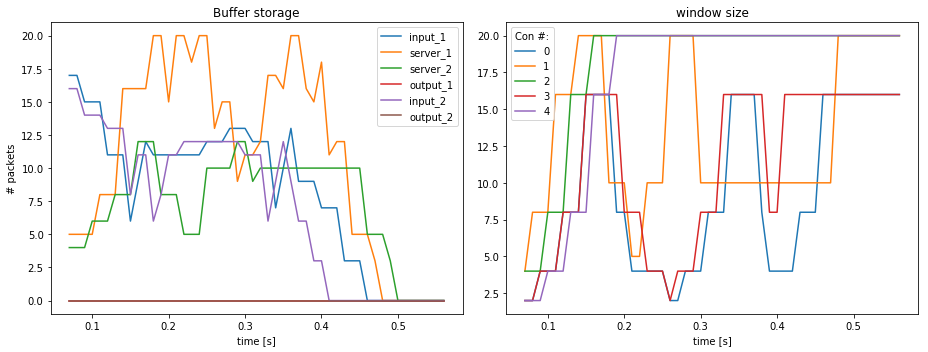

In [35]:
fig,ax = plt.subplots(1,2, figsize=[13,5])
lines = ax[0].plot(t, s_list)
ax[0].set_title('Buffer storage')
ax[0].set_ylabel('# packets')
ax[0].set_xlabel('time [s]')
ax[0].legend((lines),(nw.nodes.name.tolist()))
lines = ax[1].plot(t, win_size_list)
ax[1].legend((lines),(nw.connections.index.tolist()), title='Con #:')
ax[1].set_title('window size')
ax[1].set_xlabel('time [s]')
plt.tight_layout()
plt.show()